In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from statistics import mean, stdev
import time

<h1>Algoritmos genéticos</h1>

<p> 1) Implemente um Algoritmo Genético para o exemplo de reconhecimento de padrões
apresentado em aula. Em vez de reconhecer o número 1 seu algoritmo deve
reconhecer o número 0, representado pela bitstring [1 1 1 1 0 1 1 0 1 1 1 1]. Verifique
quantas gerações são necessárias em média para atingir o alvo. Teste diferentes taxas
de crossover e mutação e compare os resultados. Faça experimentos apenas com
crossover e apenas com mutação e compare também os resultados. </p>

In [2]:
def inicializar(size_pop, target):
    """ Inicia uma população de bitstrings aleatória com _size_pop_ cromossomos de mesmo tamanho do _alvo_"""
    return np.random.randint(2, size=(size_pop, len(target)))

In [3]:
def avaliar(P, target):
    """ Avalia a população P calculando a distância Hamming para o alvo buscado """
    size_pop, size_crom = np.size(P,0), np.size(P,1)
    h = []
    for i in range(size_pop):
        dist = 0
        for j in range(size_crom):
            if P[i][j] != target[j]:
                dist += 1
        h.append(size_crom - dist)
    return h

In [4]:
def criterioParada(f, target, t, max_it):
    """Para o algoritmo quando o máximo de iterações for atingido ou quando a maior distância Hamming encontrada for do mesmo tamanho do alvo, 
        pois isto significa que o alvo foi encontrado"""
    return max(f) != len(target) and t < max_it

In [5]:
def selecionar(P, f):
    """
    Seleciona os indíviduos para a próxima geração pelo método da roleta:
        - a probabilidade de cada indivíduo é calculada de acordo com sua aptidão, assim aqueles com maior aptidão têm mais chance de irem para a próxima geração
        - o método np.choice permite que sejam passadas as probabilidades de cada indivíduo ser escolhido e é chamado _size_pop_ vezes
    """
    size_pop = np.size(P,0)
    newP, probabilidades = np.copy(P), []
    total = sum(f)

    for i in range(size_pop):
        probabilidades.append(f[i]/total)

    for i in range(size_pop):
        index_sorteado = np.random.choice(size_pop, p=probabilidades)
        newP[i] = np.copy(P[index_sorteado])

    return newP

In [6]:
def reproduzir(P, pc, f):
    """
    Faz o cross-over entre dois cromossomos da população _P_ de acordo com a taxa de probabilidade de cross-over _pc_
        - o ponto de cross-over é escolhido aleatóriamente e armazenado na variável cp (cross-over point)
        - os cromossomos com o cross-over são salvos nas variáveis c1 e c2
    """
    size_pop, size_crom = np.size(P,0), np.size(P,1)
    newP, t = np.copy(P), 0
    while (t + 1) < size_pop:
        if np.random.uniform(0,1) < pc:
            cp = np.random.randint(low = 1, high = size_crom)
            c1 = np.append(newP[t][:cp], newP[t+1][cp:])
            c2 = np.append(newP[t+1][:cp], newP[t][cp:])
            newP[t] = np.copy(c1)
            newP[t+1] = np.copy(c2)
        t += 2
    return newP

In [7]:
def variar(P, pm, f):
    """
    Muta os cromossomos da população _P_ de acordo com a taxa de probabilidade de mutação _pm_
        - o algoritmo anda por cada bit de cada cromossomo e, se a probabilidade de mutação for favorável, o bit é invertido
    """
    size_pop, size_crom = np.size(P,0), np.size(P,1)
    newP = np.copy(P)
    for i in range(size_pop):
        for j in range(size_crom):
            if np.random.uniform(0,1) < pm:
                newP[i][j] = not newP[i][j]
    return newP

In [8]:
def buscaGenetica(pc: float, pm: float, target, 
                  inicializar: inicializar, avaliar: avaliar, criterioParada: criterioParada, 
                  selecionar: selecionar, reproduzir: reproduzir, variar: variar,
                  size_pop = 8, max_it = 1000):
    """
    Implementação "genérica" da Busca Genética para maximização

    pc --               probabilidade de cross-over
    pm --               probabilidade de mutação
    alvo --             alvo para o caso de busca onde se conhece o alvo, se não é conhecido o alvo é usado para definir o tamanho do cromossomo
    inicializar --      método para inicializar a População, espera receber os parâmetros (size_pop, target), retorna a população inicial
    avaliar --          método para avaliar a população, espera receber os parâmetros (P, target), retorna a lista avaliações para cada cromossomo na população
    criterioParada --   método para finalizar as iterações do algoritmo, espera receber os parâmetros (f, target, t, max_it), retorna um booleano
    selecionar --       método para selecionar a população da próxima geração, espera receber os parâmetros (P, f), retorna População intermediária
    reproduzir --       método para reproduzir a população selecionada, espera receber os parâmetros (P, pc, f), retorna População intermediária
    variar --           método para mutar a população após a reprodução, espera receber os parâmetros (P, pm, f), retorna População que será avaliada
    size_pop --         tamanho da população, valor padrão é 8
    max_it --           máximo de iterações, valor padrão é 1000

    retorna 
    best_value --       cromossomo com maior aptidão
    best_result --      maior aptidão obtida durante as iterações
    best_iteration --   iteração da maior aptidão
    historico --        histórico contendo a população, aptidões, média, desvio padrão, melhor aptidão e melhor cromossomo de cada iteração
    """
    historico = [{"pc": pc, "pm": pm, "size_pop": size_pop, "size_crom": len(target)}]

    P = inicializar(size_pop, target)
    f = avaliar(P, target)
    t = 0

    best_result = max(f)
    best_value = P[f.index(best_result)]
    best_iteration = t

    historico.append({"t": t, "P": P, "f": f, "best_result": max(f), "best_value": P[f.index(max(f))],"mean": mean(f), "stdev": stdev(f)})
    
    while criterioParada(f, target, t, max_it):
        P = selecionar(P, f)
        P = reproduzir(P, pc, f)
        P = variar(P, pm, f)
        f = avaliar(P, target)
        
        if(best_result < max(f)):
            best_result = max(f)
            best_value = P[f.index(best_result)]
            best_iteration = t
        
        t += 1
        historico.append({"t": t, "P": P, "f": f, "best_result": max(f), "best_value": P[f.index(max(f))],"mean": mean(f), "stdev": stdev(f)})

    return best_value, best_result, best_iteration, historico

In [9]:
bv, br, t, h = buscaGenetica(0.6, 0.02, 
                        np.array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]),
                        inicializar= inicializar,
                        avaliar= avaliar,
                        criterioParada= criterioParada,
                        selecionar= selecionar,
                        reproduzir= reproduzir,
                        variar= variar)
print(bv, '\n', br, '\n', t, '\n', h[-1])

[1 1 1 1 0 1 1 0 1 1 1 1] 
 12 
 123 
 {'t': 124, 'P': array([[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]]), 'f': [10, 8, 11, 11, 9, 8, 9, 12], 'best_result': 12, 'best_value': array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]), 'mean': 9.75, 'stdev': 1.4880476182856899}


In [10]:
def runBuscaGenetica_1(pc: float, pm: float):
    """
    Roda a busca genética 100 vezes para o exercício 1 medindo o tempo de execução e a quantidade de iterações
    """
    t_ = []
    time_ = []
    for i in range(100):
        start = time.process_time()
        bv, br, t, h = buscaGenetica(pc, pm, 
                            np.array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]),
                            inicializar= inicializar,
                            avaliar= avaliar,
                            criterioParada= criterioParada,
                            selecionar= selecionar,
                            reproduzir= reproduzir,
                            variar= variar)
        end = time.process_time()
        t_.append(t)
        time_.append(end-start)
    print("iterations \t mean: ", mean(t_), "\t\t stdev: ", stdev(t_))
    print("time \t \t mean: ", mean(time_), "\t stdev: ", stdev(time_))
    return t_, time_

In [11]:
iterations, times = runBuscaGenetica_1(0.6, 0.02)

iterations 	 mean:  129 		 stdev:  101.43286579125261
time 	 	 mean:  0.02359375 	 stdev:  0.02546666328905856


In [12]:
def variatePCPM_1():
    """
    Varia a probabilidade de Cross-Over entre 0 e 1, com passos de 0.1
    e a de Mutação entre 0 e 0.1, com passos de 0.01
    """
    t_means = []
    t_stdevs = []
    for pc in np.linspace(0, 1, 10):
        t_means_ = []
        t_stdevs_ = []
        for pm in np.linspace(0, 0.1, 10):
            print("pc: ", pc, "pm: ", pm)
            iterations, times = runBuscaGenetica_1(pc, pm)
            t_means_.append(mean(iterations))
            t_stdevs_.append(stdev(iterations))
        t_means.append(t_means_)
        t_stdevs.append(t_means_)
    return t_means, t_stdevs

In [13]:
#Demora cerca de meia hora para rodar
#t_means, t_stdevs = variatePCPM_1()

<p> 2) Implemente um Algoritmo Genético para maximizar a função 

$$
    g(x) = 2 ^{−2((x−0,1)/0,9)^2} (sin(5πx))^6
$$

já utilizada nos exercícios feitos em aula, dentro do
intervalo [0 1]. Utilize uma representação de bitstring, com precisão suficiente para
pelo menos 3 casas decimais. Considere o alvo como desconhecido e verifique quais os
maiores valores obtidos para g(x). Compare os resultados obtidos com os resultados
que você obteve com os algoritmos Subida da Colina e Recozimento Simulado
aplicados a esta mesma função em relação aos valores obtidos para g(x) e tempos de
execução. Aproveite para explorar diferentes formas de seleção, como roleta, torneio
e amostragem estocástica universal. </p>

<p>Dica: você também pode aplicar Subida da Colina e Recozimento Simulado em uma
bitstring, utilizando uma perturbação semelhante ao operador de mutação dos
algoritmos genéticos, com a vantagem de não ter de se preocupar com o domínio de x,
visto que a própria representação binária dá conta disso. </p>

In [14]:
def converte_decimal(p):
  """
  Faz a conversão do cromossomo para pontos decimais
  """
  # n é o tamanho do cromossomo
  n = np.size(p,0)
  # calcula o valor inteiro da bitstring e divide pelo maior valor que ela pode assumir (2^n - 1)
  return p.dot(2**np.arange(n)[::-1]) / ((1 << n) - 1)

In [15]:
def g(x):
    """Retorna a função g(x) do exercício 2"""
    return (2 ** (-2*((x-0.1)/(0.9))**2)) * (np.sin(5*np.pi*x)**6)

In [16]:
def avaliar_2(P, alvo):
    """
    Função de avaliação do exercícico 2:
    Para cada cromossomo na População, o seu valor é convertido para float e g(x) é calculado
    Retorna a lista de aptidões
    """
    f = []
    for p in P:
        x = converte_decimal(p)
        f.append(g(x))
    return f

In [17]:
def criterioParada_2(f, alvo, t, max_it):
    """
    Neste caso, como assumimos que não sabemos o resultado buscado e queremos ver em quantas iterações o algoritmo converge,
    o critério de parada é apenas o máximo de iterações
    """
    return t < max_it

In [18]:
def grafico_func(grafico, func):
    x = np.linspace(0, 1, 1000)
    grafico.plot(x, func(x))

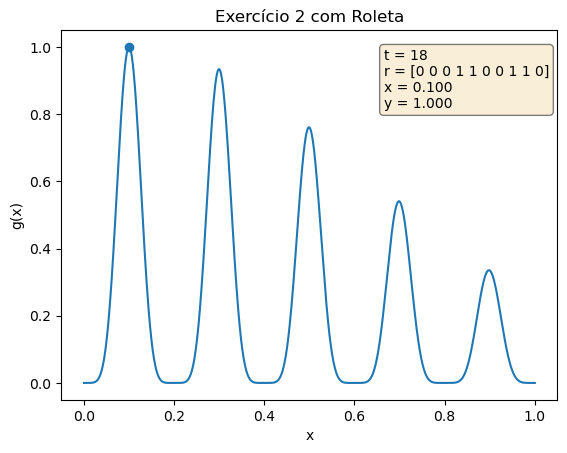

In [49]:
bv, br, t, h = buscaGenetica(0.6, 0.04,
                        # o alvo serve para definir também o tamanho do cromossomo, 
                        #como neste caso se sabe o valor buscado, passe-se um cromossomo de zeros com o tamanho desejado
                        np.zeros(10), 
                        inicializar= inicializar,
                        avaliar= avaliar_2,
                        criterioParada= criterioParada_2,
                        selecionar= selecionar,
                        reproduzir= reproduzir,
                        variar= variar, max_it=100)

fig, ax = plt.subplots()
ax.set_title('Exercício 2 com Roleta')
ax.set_xlabel("x")
ax.set_ylabel("g(x)")
grafico_func(ax, g)
ax.scatter(converte_decimal(bv), br)
txt = '\n'.join((f't = %d'%t, f'r = %s'%bv, f'x = %.3f'%converte_decimal(bv), f'y = %.3f'%br))
ax.text(0.65, 0.95, txt, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox= dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

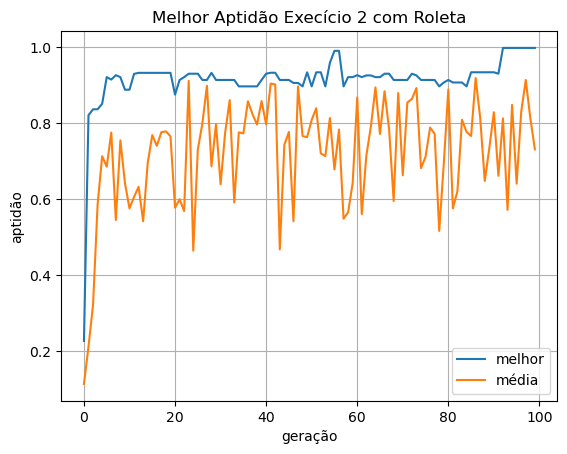

In [20]:
best_results = [a['best_result'] for a in h[2:] ]
means = [a['mean'] for a in h[2:] ]

fig, ax = plt.subplots()
ax.plot(range(0, len(h[2:])), best_results, label='melhor')
ax.plot(range(0, len(h[2:])), means, label='média')

ax.set(xlabel='geração', ylabel='aptidão', title='Melhor Aptidão Execício 2 com Roleta')
ax.legend()
ax.grid()

plt.show()

In [21]:
def runBuscaGenetica_2(pc: float, pm: float, selecao: selecionar):
    t_ = []
    time_ = []
    brs_ = []
    for i in range(100):
        start = time.process_time()
        bv, br, t, h = buscaGenetica(pc, pm,
                        # o alvo serve para definir também o tamanho do cromossomo, 
                        #como neste caso se sabe o valor buscado, passe-se um cromossomo de zeros com o tamanho desejado
                        np.zeros(10), 
                        inicializar= inicializar,
                        avaliar= avaliar_2,
                        criterioParada= criterioParada_2,
                        selecionar= selecao,
                        reproduzir= reproduzir,
                        variar= variar, max_it=100)
        end = time.process_time()
        t_.append(t)
        time_.append(end-start)
        brs_.append(br)
    print(f"best results \t mean:  %.3f"%mean(brs_), f"\t\t stdev:  %.3f"%stdev(brs_))
    print("iterations \t mean: ", mean(t_), "\t\t stdev: ", stdev(t_))
    print("time \t \t mean: ", mean(time_), "\t stdev: ", stdev(time_))
    return t_, time_

In [22]:
ts, times = runBuscaGenetica_2(0.6, 0.03, selecionar)

best results 	 mean:  0.943 		 stdev:  0.102
iterations 	 mean:  38.71 		 stdev:  30.677631438999178
time 	 	 mean:  0.01421875 	 stdev:  0.015560948261447775


<h2>Seleção por torneio </h2>

In [23]:
def selecao_torneio(P, f):
    """
    Faz a seleção por torneio, escolhendo 3 cromossomos aleatórios e distintos da População para competir, a maior aptidão entra na população intermediária 
    """
    size_pop = np.size(P, 0)
    newP = np.copy(P)
    for i in range(size_pop):
        contestants = np.random.choice(np.arange(P.shape[0]), size=3, replace=False)
        f_max = 0
        winner = 0
        for contestant in contestants:
            if(f_max < f[contestant]):
                f_max = f[contestant]
                winner = contestant
        newP[i] = np.copy(P[winner])
    return newP

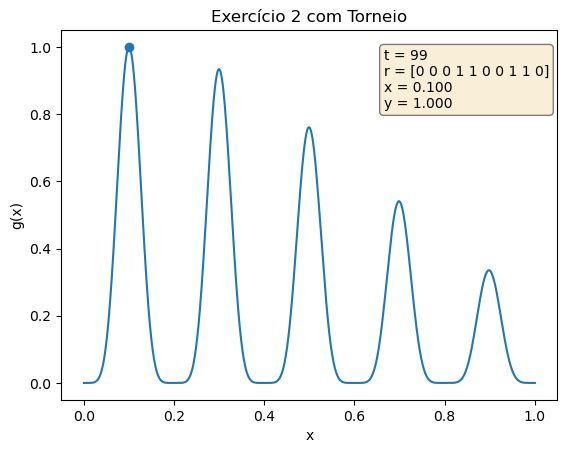

In [51]:
bv, br, t, h = buscaGenetica(0.6, 0.04, 
                        np.zeros(10), # o alvo serve para definir também o tamanho do cromossomo, como neste caso se sabe o valor buscado, passe-se um cromossomo de zeros com o tamanho desejado
                        inicializar= inicializar,
                        avaliar= avaliar_2,
                        criterioParada= criterioParada_2,
                        selecionar= selecao_torneio,
                        reproduzir= reproduzir,
                        variar= variar, max_it=100)

fig, ax = plt.subplots()
ax.set_title('Exercício 2 com Torneio')
ax.set_xlabel("x")
ax.set_ylabel("g(x)")
grafico_func(ax, g)
ax.scatter(converte_decimal(bv), br)
txt = '\n'.join((f't = %d'%t, f'r = %s'%bv, f'x = %.3f'%converte_decimal(bv), f'y = %.3f'%br))
ax.text(0.65, 0.95, txt, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox= dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

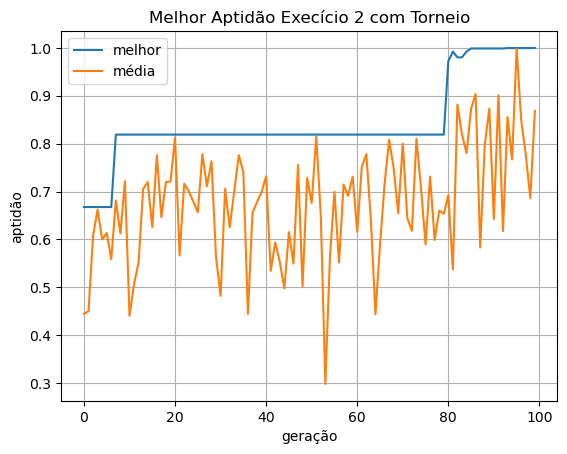

In [52]:
best_results = [a['best_result'] for a in h[2:] ]
means = [a['mean'] for a in h[2:] ]

fig, ax = plt.subplots()
ax.plot(range(0, len(h[2:])), best_results, label='melhor')
ax.plot(range(0, len(h[2:])), means, label='média')

ax.set(xlabel='geração', ylabel='aptidão', title='Melhor Aptidão Execício 2 com Torneio')
ax.legend()
ax.grid()

plt.show()

In [26]:
ts, times = runBuscaGenetica_2(0.6, 0.04, selecao_torneio)

best results 	 mean:  0.930 		 stdev:  0.113
iterations 	 mean:  29.49 		 stdev:  31.421376947755316
time 	 	 mean:  0.0190625 	 stdev:  0.016852070092844423


<h2> Seleção por Amostragem Estocástica Universal </h2>

In [27]:
def selecao_sus(P, f):
    """
    Seleciona os cromossomos por Amostragem Estocástica Universal, montando a roleta com as probabilidades e em uma rodada define a próxima população
    """
    size_pop = np.size(P,0)
    newP, probabilidades = np.copy(P), []
    total = sum(f)

    for i in range(size_pop):
        probabilidades.append(f[i]/total)
    
    P_idxs = np.random.choice(size_pop, p=probabilidades, size=size_pop)

    for i in range(size_pop):
        newP[i] = np.copy(P[P_idxs[i]])
    return newP

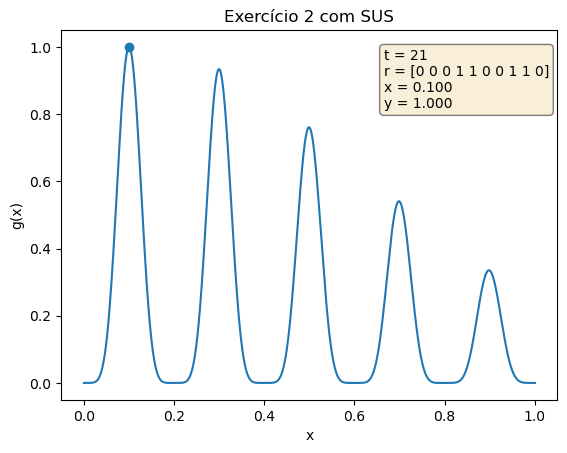

In [28]:
bv, br, t, h = buscaGenetica(0.6, 0.04, 
                        np.zeros(10), # o alvo serve para definir também o tamanho do cromossomo, como neste caso se sabe o valor buscado, passe-se um cromossomo de zeros com o tamanho desejado
                        inicializar= inicializar,
                        avaliar= avaliar_2,
                        criterioParada= criterioParada_2,
                        selecionar= selecao_sus,
                        reproduzir= reproduzir,
                        variar= variar, max_it=100)

fig, ax = plt.subplots()
ax.set_title('Exercício 2 com SUS')
ax.set_xlabel("x")
ax.set_ylabel("g(x)")
grafico_func(ax, g)
ax.scatter(converte_decimal(bv), br)
txt = '\n'.join((f't = %d'%t, f'r = %s'%bv, f'x = %.3f'%converte_decimal(bv), f'y = %.3f'%br))
ax.text(0.65, 0.95, txt, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox= dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

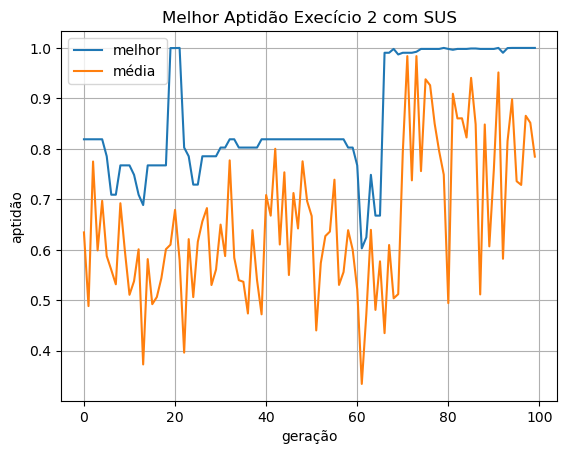

In [29]:
best_results = [a['best_result'] for a in h[2:] ]
means = [a['mean'] for a in h[2:] ]

fig, ax = plt.subplots()
ax.plot(range(0, len(h[2:])), best_results, label='melhor')
ax.plot(range(0, len(h[2:])), means, label='média')

ax.set(xlabel='geração', ylabel='aptidão', title='Melhor Aptidão Execício 2 com SUS')
ax.legend()
ax.grid()

plt.show()

In [30]:
t_sus, time_sus = runBuscaGenetica_2(0.6, 0.04, selecao_sus)

best results 	 mean:  0.931 		 stdev:  0.120
iterations 	 mean:  40.65 		 stdev:  30.84807182553774
time 	 	 mean:  0.01265625 	 stdev:  0.013814807956546578


<p> 3)  Utilize um Algoritmo Genético para minimizar a seguinte função no intervalo contínuo

$$
 \begin{bmatrix}-10 & +10\\-10 & +10\end{bmatrix}
$$

$$
f(x, y) = (1 − x)^2 + 100(y − x^2)^2
$$

Considere o alvo como desconhecido e verifique quais os maiores valores obtidos para
g(x). Aproveite para testar diferentes tamanhos de população, sem elitismo e com
elitismo com diferentes quantidades de indivíduos.
</p>

In [31]:
def k(x, y):
    """
    Define a função f(x, y) para o exercício 3, chamando de k
    """
    return (1 - x)**2 + 100 * (y - (x**2))**2

In [32]:
def generateGreyCodeList(n):
    """
    Gera lista de Códigos Grey para bitstrings de _n_ bits
    """
    greyCodeList = []
    for i in range(1 << n):
        g = i^(i>>1)
        greyCodeList.append(bin(g)[2:].zfill(n))
    return greyCodeList


In [33]:
def dictGreyCode(n, min, max):
    """
    Gera cicionário com valores em escala para a lista de códigos de Grey
    """
    greyCodeList = generateGreyCodeList(n)
    dif = (2**n) - (max - min)
    duplicatedValues = [n for n in range(min, max) if (n % 2 == 0) or (max - n) <= 2*(dif - ((max-min)//2))]
    greyCodeScaleDict = {}
    counter = 0
    for code in greyCodeList:
        greyCodeScaleDict[code] = min
        if(min not in duplicatedValues or counter == 1):
            min += 1
            counter = 0
        else:
            counter = 1
    return greyCodeScaleDict

In [34]:
def converte_real(code, dec_point, codeTable):
    """
    Converte uma bitstring para um npumero real de acordo com a tabela de códigos passada e ponto decimal
    O primeiro bit da string recebida indica o sinal do número
    A parte inteira do número é convertidade com o Código de Grey, são os n primeiros bits pulando o primeiro até _dec_point_
    A parte decimal é convertida usando a mesma função de conversão do Exercício 2, são os últimos m bits de dec_point até o final
    """
    if (code[0] == 0):
        s = 1
    else:
        s = -1
    p_int = codeTable[''.join([str(bit) for bit in code[1:dec_point]])]
    p_dec = converte_decimal(code[dec_point:])
    return s * (p_int + p_dec)

In [35]:
def converte_3(p):
    """
    Converte o cromossomo para dois valores reais x e y. 
    O Cromossomo completo tem 18 bits, os 9 primeiros representam x, os 9 últimos representam y
    Dentro dos 9 dígitos, o primeiro indica o sinal, os 4 seguintes a parte inteira e os últimos 4 a parte decimal,
    sendo assim, _dec_point_ (ponto decimal) é 1 + 4 = 5
    """
    codeTable = dictGreyCode(4, 0, 10)
    x = converte_real(p[:9], 5, codeTable)
    y =  converte_real(p[9:], 5, codeTable)
    return x, y


In [36]:
def avaliar_3(P, alvo):
    """Avaliar f(x,y), convertendo a bitstring e avaliando a função;
    Como é uma minimização, multiplica-se o resultado por -1, para que a busca genética "maximize ao contrário" """
    f = []
    for p in P:
        x, y = converte_3(p)
        f.append(-1 * k(x, y))
    return f

In [37]:
def selecionar_3(P, f):
    """
    Seleciona os cromossomos para o Exercício 3
    Como as aptidões foram invertidas, deslocam-se os valores de f para que o maior valor seja 0 somando o menor valor encontrado em f em cada elemento 
    """
    size_pop = np.size(P,0)
    newP, probabilidades = np.copy(P), []
    f = f + abs(min(f))
    total = sum(f)

    for i in range(size_pop):
        probabilidades.append(f[i]/total)

    for i in range(size_pop):
        index_sorteado = np.random.choice(size_pop, p=probabilidades)
        newP[i] = np.copy(P[index_sorteado])

    return newP

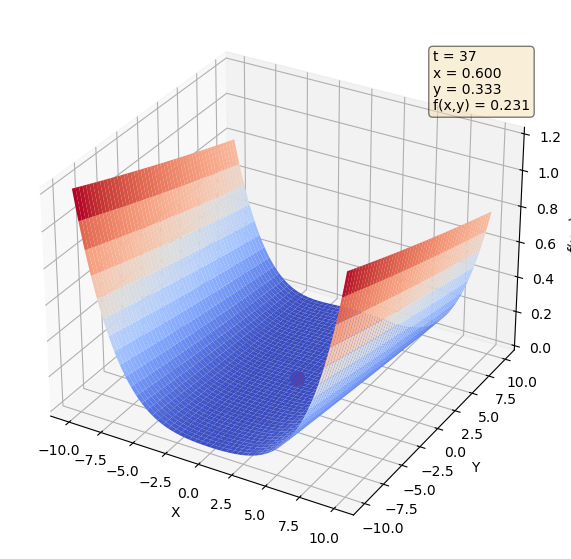

In [66]:
br, bv, t, h = buscaGenetica(0.6, 0.05, 
                        # o alvo serve para definir também o tamanho do cromossomo, 
                        #como neste caso se sabe o valor buscado, passe-se um cromossomo de zeros com o tamanho desejado
                        np.zeros(18), 
                        inicializar= inicializar,
                        avaliar= avaliar_3,
                        criterioParada= criterioParada_2,
                        selecionar= selecionar_3,
                        reproduzir= reproduzir,
                        variar= variar,
                        size_pop= 50, max_it=100)
x_, y_ = converte_3(br)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-10.0, 10.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(k(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap = cm.coolwarm)
ax.plot(x_, y_, k(x_, y_), color='red', marker='o', markersize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x,y)')

txt = '\n'.join((f't = %d'%t, f'x = %.3f'%x_, f'y = %.3f'%y_, f'f(x,y) = %.3f'%k(x_, y_)))
ax.text(-15, 50, 1, txt, fontsize=10, verticalalignment='top', bbox= dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()


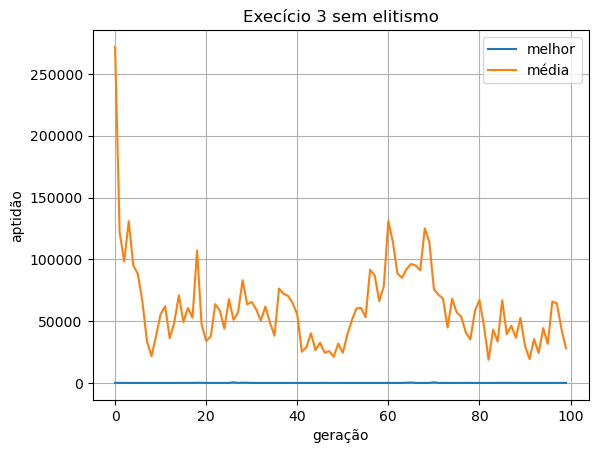

In [67]:
best_results = [-1 * a['best_result'] for a in h[2:] ]
means = [-1 * a['mean'] for a in h[2:] ]

fig, ax = plt.subplots()
ax.plot(range(0, len(h[2:])), best_results, label='melhor')
ax.plot(range(0, len(h[2:])), means, label='média')

ax.set(xlabel='geração', ylabel='aptidão', title='Execício 3 sem elitismo')
ax.legend()
ax.grid()

plt.show()

In [68]:
def runBuscaGenetica_3(pc: float, pm: float, reproducao: reproduzir, variacao: variar):
    t_ = []
    time_ = []
    k_, x_, y_ = [], [], []
    for i in range(100):
        start = time.process_time()
        br, bv, t, h = buscaGenetica(0.6, 0.05, 
                        np.zeros(18),
                        inicializar= inicializar,
                        avaliar= avaliar_3,
                        criterioParada= criterioParada_2,
                        selecionar= selecionar_3,
                        reproduzir= reproducao,
                        variar= variacao,
                        size_pop= 50, max_it=300)
        end = time.process_time()
        t_.append(t)
        time_.append(end-start)
        x__, y__ = converte_3(br)
        x_.append(x__)
        y_.append(y__)
        k_.append(k(x__, y__))
    print("iterations \t mean: ", mean(t_), "\t\t stdev: ", stdev(t_))
    print("x \t\t mean: ", mean(x_), "\t\t stdev: ", stdev(x_))
    print("y \t\t mean: ", mean(y_), "\t\t stdev: ", stdev(y_))
    print("f(x,y) \t\t mean: ", mean(k_), "\t\t stdev: ", stdev(k_))
    print("time \t \t mean: ", mean(time_), "\t stdev: ", stdev(time_))
    return t_, time_, k_, x_, y_

In [69]:
t_, time_, k_, x_, y_ = runBuscaGenetica_3(0.6, 0.05, reproducao = reproduzir, variacao= variar)

iterations 	 mean:  136.64 		 stdev:  82.28694804269884
x 		 mean:  0.9693333333333334 		 stdev:  0.14099852344587493
y 		 mean:  0.9546666666666667 		 stdev:  0.27165039921549794
f(x,y) 		 mean:  0.041402469135802505 		 stdev:  0.06377169268415116
time 	 	 mean:  0.60921875 	 stdev:  0.15899568336268494


<h2>Elitismo<h2>

In [42]:
def reproduzir_elitismo(P, pc, f):
    """
    Reproduz a população, evitando que o melhor seja alterado pelo cross-over
    """
    best_crom_idx = f.index(max(f))
    size_pop, size_crom = np.size(P,0), np.size(P,1)
    newP, t = np.copy(P), 0
    while (t + 1) < size_pop:
        if (np.random.uniform(0,1) < pc and best_crom_idx not in [t, t+1]):
            cp = np.random.randint(low = 1, high = size_crom)
            c1 = np.append(newP[t][:cp], newP[t+1][cp:])
            c2 = np.append(newP[t+1][:cp], newP[t][cp:])
            newP[t] = np.copy(c1)
            newP[t+1] = np.copy(c2)
        t += 2
    return newP

In [43]:
def variar_elitismo(P, pm, f):
    """
    Varia a população, evitando que o melhor seja mutado
    """
    best_crom_idx = f.index(max(f))
    size_pop, size_crom = np.size(P,0), np.size(P,1)
    newP = np.copy(P)
    for i in range(size_pop):
        if i == best_crom_idx:
            continue
        for j in range(size_crom):
            if (np.random.uniform(0,1) < pm):
                newP[i][j] = not newP[i][j]
    return newP

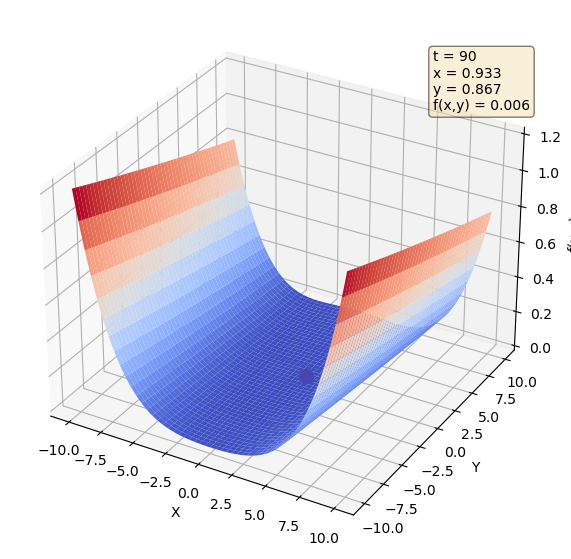

In [70]:
br, bv, t, h = buscaGenetica(0.6, 0.05, 
                        np.zeros(18), # o alvo serve para definir também o tamanho do cromossomo, como neste caso se sabe o valor buscado, passe-se um cromossomo de zeros com o tamanho desejado
                        inicializar= inicializar,
                        avaliar= avaliar_3,
                        criterioParada= criterioParada_2,
                        selecionar= selecionar_3,
                        reproduzir= reproduzir_elitismo,
                        variar= variar_elitismo,
                        size_pop= 50, max_it=100)

x_, y_ = converte_3(br)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-10.0, 10.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(k(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap = cm.coolwarm)
ax.plot(x_, y_, k(x_, y_), color='red', marker='o', markersize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x,y)')

txt = '\n'.join((f't = %d'%t, f'x = %.3f'%x_, f'y = %.3f'%y_, f'f(x,y) = %.3f'%k(x_, y_)))
ax.text(-15, 50, 1, txt, fontsize=10, verticalalignment='top', bbox= dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()


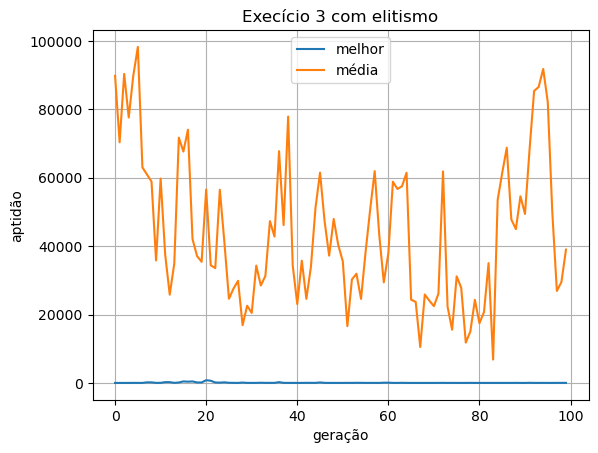

In [71]:
best_results = [-1 * a['best_result'] for a in h[2:] ]
means = [-1 * a['mean'] for a in h[2:] ]

fig, ax = plt.subplots()
ax.plot(range(0, len(h[2:])), best_results, label='melhor')
ax.plot(range(0, len(h[2:])), means, label='média')

ax.set(xlabel='geração', ylabel='aptidão', title='Execício 3 com elitismo')
ax.legend()
ax.grid()

plt.show()

In [72]:
t_, time_, k_, x_, y_ = runBuscaGenetica_3(0.6, 0.05, reproducao=reproduzir_elitismo, variacao=variar_elitismo)

iterations 	 mean:  131.97 		 stdev:  83.2740947022833
x 		 mean:  0.9413333333333334 		 stdev:  0.11958776930732187
y 		 mean:  0.896 		 stdev:  0.21531070129473692
f(x,y) 		 mean:  0.03336296296296303 		 stdev:  0.058010975287440376
time 	 	 mean:  0.27484375 	 stdev:  0.10515851186837522


<p> Para todos os exercícios, faça um relatório contendo os dados de todos os seus

experimentos, configurações utilizadas, resultados obtidos e suas conclusões. Lembre-
se de otimizar os hiperparâmetros dos algoritmos para obter os melhores resultados e

de repetir os experimentos nas mesmas condições diversas vezes para obter média e
desvio padrão, visto que os algoritmos são estocásticos. Você também pode usar as
diferentes versões do algoritmo apresentadas (representação, seleção, etc.) para
verificar qual se adequa melhor a cada problema.
Além de encontrar um indivíduo com boa aptidão, também é desejável que o
algoritmo tenha uma convergência rápida. Portanto, registre também o número de
iterações e tempo que os algoritmos demoram para convergir, dados os valores
atribuídos aos hiperparâmetros.
Para cada experimento, inclua em seu relatório um ou mais gráficos que mostrem o
valor mínimo e médio da função de aptidão ao longo das iterações. </p>

<p>Observações:</p>
<p>1) Qualquer linguagem de programação e ambiente de desenvolvimento podem ser
utilizados. Porém o código-fonte deve ser devidamente comentado.</p>
<p>2) O relatório deve ser entregue em formato PDF, através de upload no Google
Classroom. Deixe o PDF separado dos códigos (não comprima o PDF em um arquivo
.zip ou similar).</p>
<p>3) Não é necessário anexar códigos-fontes no PDF. Os códigos-fontes podem ser
postados em um ou mais arquivos separados no Google Classroom. Estes podem ser
compactados (.zip ou similar).</p>